# Dictionary-based TSC
> From stracth implementation of the Bag of SFA Symbols (BOSS) algorithm 
for time series classification. For a high-level
usage of this algorithm, and more dictionary-based for TSC, go to 
[the aeon library](https://github.com/aeon-toolkit/aeon/blob/main/examples/classification/dictionary_based.ipynb)

In [2]:
# Importing the required libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load and Preprocess the Time Series Data
Load the time series data and preprocess it by normalizing and segmenting it into windows.

In [3]:
# Generate a synthetic dataset of univariate time series
from sklearn.datasets import make_classification

# Define the number of samples, time steps and features
n_samples = 1000
n_timesteps = 50
n_features = 1

# Generate the dataset
X, y = make_classification(n_samples=n_samples, n_features=n_timesteps, n_informative=2, 
                            n_redundant=0, n_clusters_per_class=1, random_state=42)

# Reshape the data to be suitable for time series classification
X = X.reshape((n_samples, n_features, n_timesteps))

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (1000, 1, 50)
y shape: (1000,)


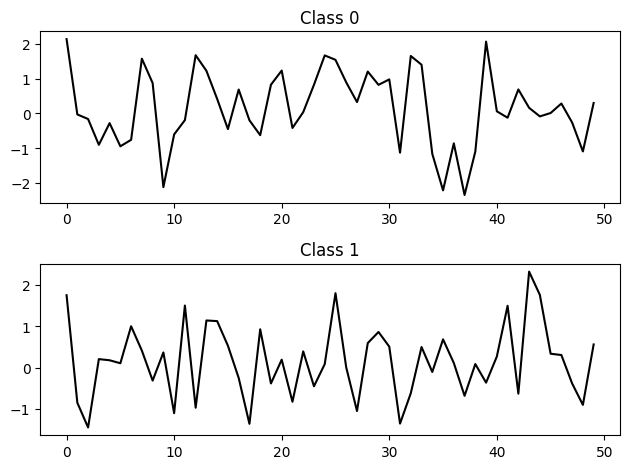

In [4]:
# plot one sample for each class
import matplotlib.pyplot as plt

for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(X[y == i][0].ravel(), 'k-')
    plt.title(f'Class {i}')
plt.tight_layout()
plt.show()

## Preprocess the data (normalization and windowing)

In [5]:
# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# Preprocess the data removing the last dimension (there's just one feature)
X = X.reshape(X.shape[0], -1)

# Convert the labels to integers
y = y.astype(int)

print(f'X shape: {X.shape}')

X shape: (1000, 50)


In [6]:
# Segment the data into windows
def segment_data(data, window_size):
    windows = []
    for i in range(0, len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

# test the function
foo = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
bar = segment_data(foo, 3)
print(f'Original data: {foo}')
print(f'Segmented data: {bar}')

Original data: [1 2 3 4 5 6 7 8 9]
Segmented data: [[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]


In [8]:
ws = 10
X_sw = np.lib.stride_tricks.sliding_window_view(X, ws, axis=1).squeeze()

print(f'X_sw shape: {X_sw.shape}')

X_sw shape: (1000, 41, 10)


# Implement Symbolic Fourier Approximation (SFA)
Implement the SFA to transform the time series data into a symbolic representation.

Original series: [ 1.71642853 -0.84426785 -1.49740012  0.27602388  0.14349283  0.12496936
  0.82558941  0.42273097 -0.30951894  0.33259907]
SFA transform: ['e' 'b' 'e' 'e' 'e' 'd' 'e' 'e' 'e' 'b']


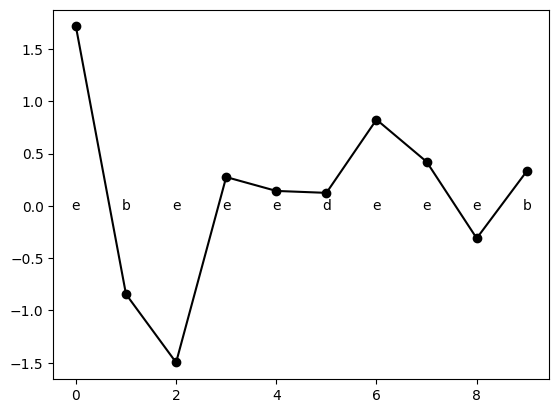

In [11]:
from scipy.fftpack import fft

def sfa_transform(series, n_coefs, alphabet_size, return_as_string=False):
    # Fourier transform
    fourier_coefs = fft(series)
    # Keep only the first n_coefs coefficients
    fourier_coefs = fourier_coefs[:, :n_coefs]
    # Discretize the coefficients into bins
    breakpoints = np.linspace(-1, 1, alphabet_size + 1)[1:-1]
    sfa_symbols = np.empty_like(fourier_coefs, dtype=str)

    for i in range(fourier_coefs.shape[0]):
        for j in range(fourier_coefs.shape[1]):
            # Find the alphabet symbol that corresponds to the FFT value
            symbol = np.sum(breakpoints <= fourier_coefs[i, j])
            sfa_symbols[i, j] = chr(ord('a') + symbol)  # Convert to a character a-z
        
    if return_as_string:
        return ''.join(map(str, sfa_symbols))
    else:
        return sfa_symbols

# test
foo = X_sw[0]
bar = sfa_transform(foo, n_coefs=len(foo), alphabet_size=5)
print(f'Original series: {foo[0]}')
print(f'SFA transform: {bar[0]}')

# plot the original series for the first element, along with the SFA symbols as 
# text aligned with the x-axis
plt.plot(foo[0], 'k-')
plt.scatter(range(len(foo[0])), foo[0], c='k')
for i, symbol in enumerate(bar[0]):
    plt.text(i, 0, symbol, ha='center', va='center')
plt.show()



In [12]:
# Apply the SFA transform to the whole dataset
n_coefs = ws
alphabet_size = 5
X_sfa = np.array([sfa_transform(series, n_coefs, alphabet_size) for series in X_sw])

print(f'X_sfa shape: {X_sfa.shape}')

X_sfa shape: (1000, 41, 10)


# Create Word from SFA Coefficients
Create words from the SFA coefficients by quantizing the coefficients into bins and assigning a symbol to each bin.

In [13]:
# Create words from SFA symbols
word_length = 4
words = []

for i in range(X_sfa.shape[0]):
    words_i = []
    for j in range(X_sfa.shape[1]):
    # Create a word for each window
        word = ''.join(X_sfa[i, j, :word_length])
        words_i.append(word)
    words.append(words_i)

# Print the words
print(words)

[['ebee', 'aaaa', 'eaca', 'ecab', 'edae', 'eeeb', 'eeea', 'ebae', 'caae', 'eaea', 'daea', 'eeae', 'abac', 'eeea', 'ceec', 'acee', 'ceaa', 'ddaa', 'ebae', 'daee', 'eaea', 'eaab', 'eaae', 'caaa', 'eeea', 'eeee', 'ceae', 'ceaa', 'deea', 'bcee', 'aaee', 'aaaa', 'eeab', 'eeaa', 'eecd', 'eeea', 'eaaa', 'eaae', 'eada', 'eaea', 'eaee'], ['eaad', 'eaaa', 'eeee', 'eeec', 'ecde', 'cebe', 'eeea', 'ceca', 'eece', 'ceab', 'daca', 'eaee', 'eabc', 'eaaa', 'eaaa', 'ecee', 'ebea', 'eeec', 'eeae', 'edac', 'edeb', 'ecee', 'eded', 'baaa', 'eece', 'eeaa', 'ecce', 'eaee', 'bada', 'caed', 'eece', 'eeaa', 'aeab', 'deee', 'aaea', 'aaed', 'abae', 'aaaa', 'aeea', 'aeec', 'aeae'], ['beae', 'aaee', 'aaea', 'acea', 'beae', 'deab', 'eeda', 'edee', 'daee', 'aaac', 'ebaa', 'eeda', 'eebe', 'ecae', 'ecea', 'edea', 'eeae', 'ebad', 'eaaa', 'eaec', 'eaed', 'eaac', 'eaac', 'eeec', 'eeea', 'edae', 'eaae', 'eaeb', 'aaea', 'aeee', 'aeae', 'aeaa', 'aede', 'aeee', 'aaea', 'aacc', 'aaae', 'baaa', 'ebba', 'eeee', 'ccdd'], ['eeee', 

# Build the Bag of SFA Symbols (BOSS)
Build the BOSS by creating a histogram of the words for each time series.

[(('ebee', 'aaaa', 'eaca', 'ecab', 'edae', 'eeeb', 'eeea', 'ebae', 'caae', 'eaea', 'daea', 'eeae', 'abac', 'eeea', 'ceec', 'acee', 'ceaa', 'ddaa', 'ebae', 'daee', 'eaea', 'eaab', 'eaae', 'caaa', 'eeea', 'eeee', 'ceae', 'ceaa', 'deea', 'bcee', 'aaee', 'aaaa', 'eeab', 'eeaa', 'eecd', 'eeea', 'eaaa', 'eaae', 'eada', 'eaea', 'eaee'), 1), (('eaad', 'eaaa', 'eeee', 'eeec', 'ecde', 'cebe', 'eeea', 'ceca', 'eece', 'ceab', 'daca', 'eaee', 'eabc', 'eaaa', 'eaaa', 'ecee', 'ebea', 'eeec', 'eeae', 'edac', 'edeb', 'ecee', 'eded', 'baaa', 'eece', 'eeaa', 'ecce', 'eaee', 'bada', 'caed', 'eece', 'eeaa', 'aeab', 'deee', 'aaea', 'aaed', 'abae', 'aaaa', 'aeea', 'aeec', 'aeae'), 1), (('beae', 'aaee', 'aaea', 'acea', 'beae', 'deab', 'eeda', 'edee', 'daee', 'aaac', 'ebaa', 'eeda', 'eebe', 'ecae', 'ecea', 'edea', 'eeae', 'ebad', 'eaaa', 'eaec', 'eaed', 'eaac', 'eaac', 'eeec', 'eeea', 'edae', 'eaae', 'eaeb', 'aaea', 'aeee', 'aeae', 'aeaa', 'aede', 'aeee', 'aaea', 'aacc', 'aaae', 'baaa', 'ebba', 'eeee', 'ccdd')

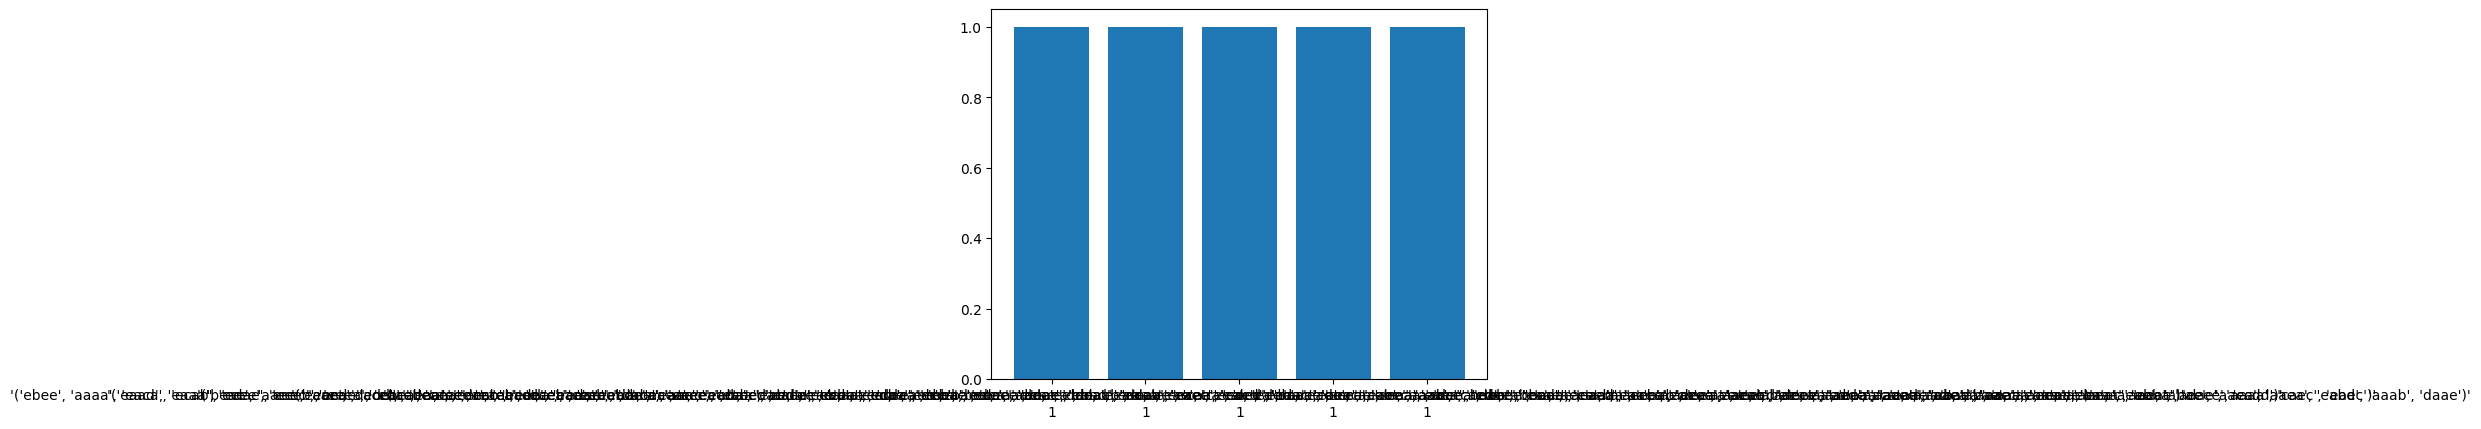

In [14]:
# Build the Bag of SFA Symbols (BOSS)
from collections import Counter

# Convert the list of words into tuples
words_tuples = [tuple(word) for word in words]

# Create a histogram of the words for each time series
word_counts = Counter(words_tuples)

# Print the word counts
print(word_counts.most_common(5))

# Plot the most common words as a histogram
plt.bar(range(5), [count for word, count in word_counts.most_common(5)])
plt.xticks(range(5), [f'\'{word}\'\n{count}' for word, count in word_counts.most_common(5)])
plt.show()

# Classify Time Series Using BOSS
Use the BOSS to classify the time series by comparing the histograms using a distance measure.

In [15]:
# Classify Time Series Using BOSS
# Define the distance measure for comparing histograms
def histogram_distance(hist1, hist2):
    # Convert histogram values to numpy arrays
    hist1 = np.array(list(hist1.values()))
    hist2 = np.array(list(hist2.values()))
    
    # Use the Euclidean distance between the two histograms
    return np.sqrt(np.sum((hist1 - hist2) ** 2))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(words, y, test_size=0.2, random_state=42)

# Create a master list of all unique words in the dataset
unique_words = set(word for sample in X_train + X_test for word in sample)

# Function to create a histogram for a sample using the master list of words
def create_histogram(sample, master_list):
    # Initialize the histogram with zeros for all words in the master list
    hist = {word: 0 for word in master_list}
    # Update counts from the sample
    hist.update(Counter(sample))
    return hist

# Convert the training and testing data into histograms using the master list
X_train_hist = [create_histogram(x, unique_words) for x in X_train]
X_test_hist = [create_histogram(x, unique_words) for x in X_test]

# Classify the testing data
y_pred = []

for test_hist in X_test_hist:
    # Convert histogram values to numpy arrays
    test_hist_values = np.array(list(test_hist.values()))
    
    # Find the training histogram that is closest to the testing histogram
    distances = []
    for train_hist in X_train_hist:
        train_hist_values = np.array(list(train_hist.values()))
        distance = np.sqrt(np.sum((test_hist_values - train_hist_values) ** 2))
        distances.append(distance)
        
    closest_index = np.argmin(distances)
    y_pred.append(y_train[closest_index])

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52       103
           1       0.49      0.51      0.50        97

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200

